# 00. 개발 환경 설정

## 00-0. 필요 라이브러리 설치

In [7]:
!pip3 install torch

## 00-1. 라이브러리 import

In [8]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

## 00-2. 학습 디바이스 정의

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Now using {device}.")

Now using cuda.


# 01. 학습 준비

## 01-0. 구글 드라이브 마운트 및 설정

In [10]:
from google.colab import drive
drive.mount('/content/drive')

#os.chdir('/content/drive/MyDrive/AI_Security/Adversarial Examples')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 01-1. 데이터셋 로드 및 전처리

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 간단한 정규화
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## 01-02. 데이터셋 시각화

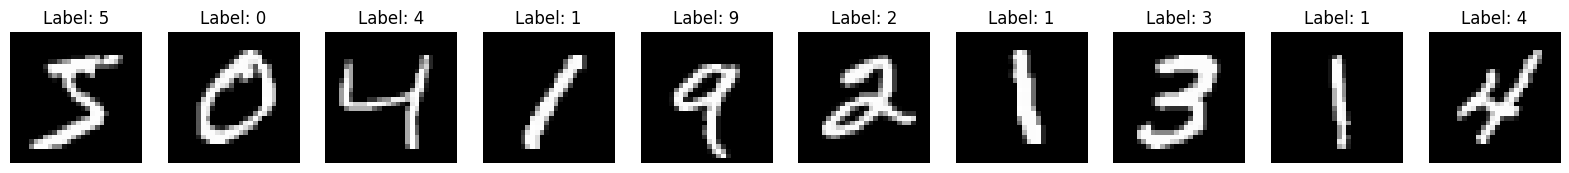

In [12]:
def show_images_with_labels(dataset, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    for i in range(num_images):
        image, label = dataset[i]
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

show_images_with_labels(train_dataset, num_images=10)

# 02. 모델 준비

## 02-01. 간단한 CNN


In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x



# 03. 모델 학습

## 03-01. 모델 학습 및 가중치 저장

In [14]:
model_dir = './model'
os.makedirs(model_dir, exist_ok=True)

# 모델 초기화
model = CNN()
model = model.cuda()

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.cuda(), labels.cuda()

        # 기존 gradient 초기화
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 100번째 배치마다 손실과 학습률 출력
        if (i+1) % 100 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], '
                  f'Loss: {running_loss/100:.4f}, Learning Rate: {current_lr}')
            running_loss = 0.0

# 학습된 모델 가중치 저장
model_path = os.path.join(model_dir, 'CNN_mnist.pth')
torch.save(model.state_dict(), model_path)

Epoch [1/5], Step [100/938], Loss: 0.7486, Learning Rate: 0.001
Epoch [1/5], Step [200/938], Loss: 0.1845, Learning Rate: 0.001
Epoch [1/5], Step [300/938], Loss: 0.1231, Learning Rate: 0.001
Epoch [1/5], Step [400/938], Loss: 0.1219, Learning Rate: 0.001
Epoch [1/5], Step [500/938], Loss: 0.0890, Learning Rate: 0.001
Epoch [1/5], Step [600/938], Loss: 0.0765, Learning Rate: 0.001
Epoch [1/5], Step [700/938], Loss: 0.0719, Learning Rate: 0.001
Epoch [1/5], Step [800/938], Loss: 0.0789, Learning Rate: 0.001
Epoch [1/5], Step [900/938], Loss: 0.0643, Learning Rate: 0.001
Epoch [2/5], Step [100/938], Loss: 0.0503, Learning Rate: 0.001
Epoch [2/5], Step [200/938], Loss: 0.0550, Learning Rate: 0.001
Epoch [2/5], Step [300/938], Loss: 0.0479, Learning Rate: 0.001
Epoch [2/5], Step [400/938], Loss: 0.0497, Learning Rate: 0.001
Epoch [2/5], Step [500/938], Loss: 0.0422, Learning Rate: 0.001
Epoch [2/5], Step [600/938], Loss: 0.0525, Learning Rate: 0.001
Epoch [2/5], Step [700/938], Loss: 0.046

# 04. 모델 검증

## 04-01.학습한 모델 Test


In [15]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the 10000 test images: {100 * correct / total:.2f}%')

Accuracy of the model on the 10000 test images: 99.13%


##04-02. 모델의 Test 결과

Image 1:
Label: 7
Prediction: 7


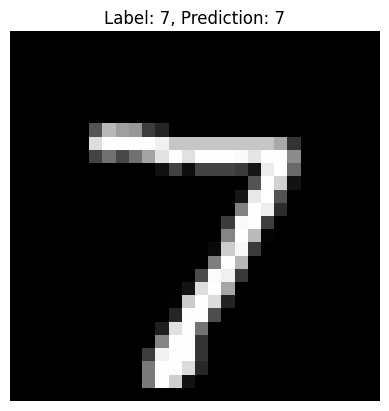

Image 2:
Label: 2
Prediction: 2


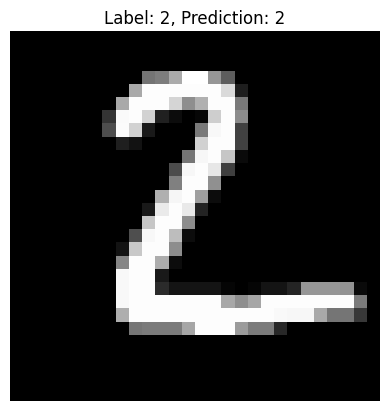

Image 3:
Label: 1
Prediction: 1


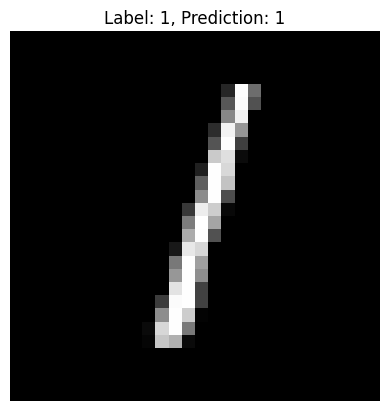

Image 4:
Label: 0
Prediction: 0


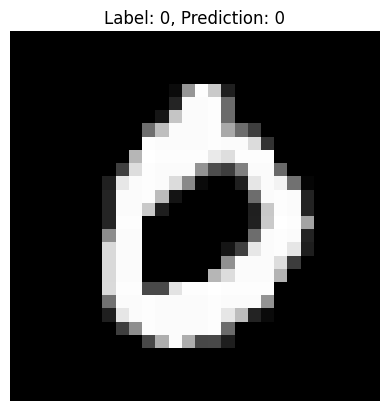

Image 5:
Label: 4
Prediction: 4


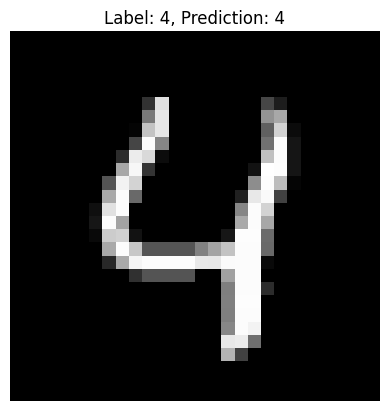

Image 6:
Label: 1
Prediction: 1


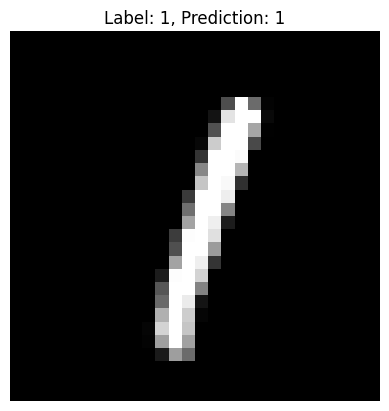

Image 7:
Label: 4
Prediction: 4


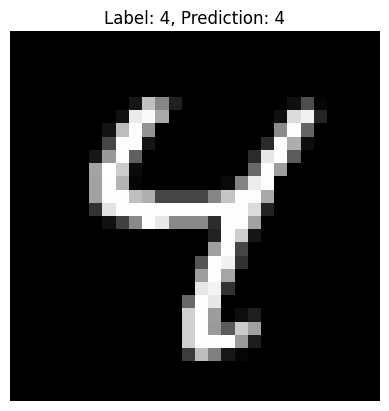

Image 8:
Label: 9
Prediction: 9


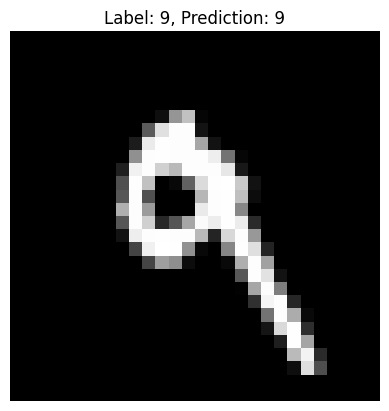

Image 9:
Label: 5
Prediction: 5


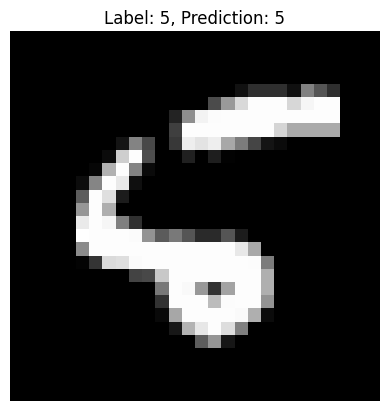

Image 10:
Label: 9
Prediction: 9


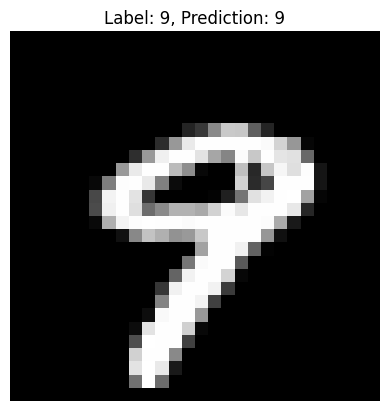

In [17]:
# 이미지 시각화를 위한 함수
def imshow(img, title):
    img = img.detach().cpu().numpy().squeeze()  # detach()를 사용하여 gradient 추적을 중단하고 numpy 배열로 변환
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

test_images = []
test_labels = []
test_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # 10개 이미지 선택
        if len(test_images) < 10:
            test_images.append(images.cpu())
            test_labels.append(labels.cpu())
            test_predictions.append(predicted.cpu())

        if len(test_images) >= 10:
            break

# 이미지, 라벨, 예측 결과를 텐서로 변환
test_images = torch.cat(test_images)[:10]
test_labels = torch.cat(test_labels)[:10]
test_predictions = torch.cat(test_predictions)[:10]

# 예측 결과 출력 및 시각화
for i in range(10):
    print(f"Image {i+1}:")
    print(f"Label: {test_labels[i].item()}")
    print(f"Prediction: {test_predictions[i].item()}")

    # 원본 이미지 시각화
    imshow(test_images[i], title=f"Label: {test_labels[i].item()}, Prediction: {test_predictions[i].item()}")

# 05. FGSM 구현 및 결과


## 05-01. FGSM 공격

In [18]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

## 05-02. FGMS 공격 수행

In [19]:
# 학습한 CNN 모델의 가중치 로드

model_path = os.path.join(model_dir, 'CNN_mnist.pth')
model.load_state_dict(torch.load(model_path))


# Test dataset 처음 10개 이미지 선택

data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images[:10].cuda(), labels[:10].cuda()
images.requires_grad = True

# 원본 이미지 예측
outputs = model(images)
init_preds = outputs.max(1, keepdim=True)[1]

# 손실 계산
loss = nn.CrossEntropyLoss()(outputs, labels)
model.zero_grad()
# 역전파 수행하여 입력 이미지에 대한 gradient 계산
loss.backward()

# FGSM 공격 수행
data_grads = images.grad.data
epsilon = 0.7  # 공격의 강도 설정 (ex: 0.1, 0.3, 0.5, 0.7 )
perturbed_images = fgsm_attack(images, epsilon, data_grads)

# 공격 이미지 예측
outputs = model(perturbed_images)
final_preds = outputs.max(1, keepdim=True)[1]



<ipython-input-19-767b61bb32e1>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


## 05-03. 공격 수행 시각화


Image 1:
Original Label: 7
Initial Prediction: 7
Final Prediction: 3 


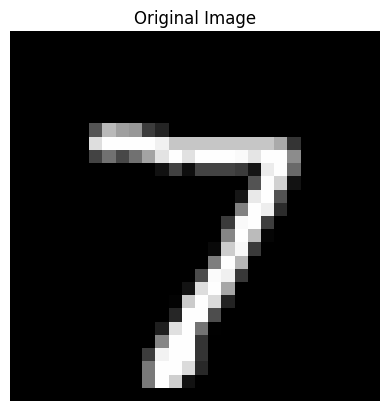

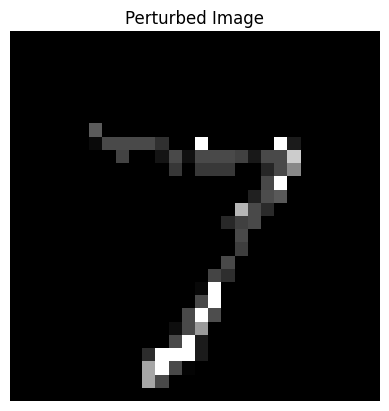

Image 2:
Original Label: 2
Initial Prediction: 2
Final Prediction: 6 


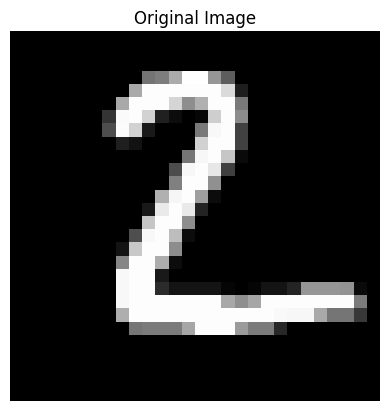

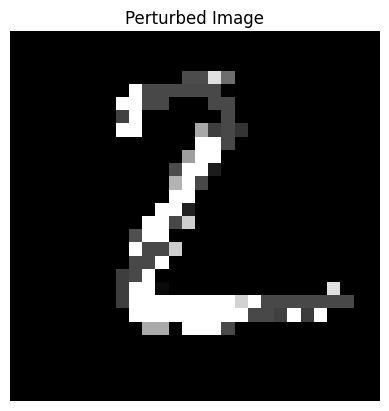

Image 3:
Original Label: 1
Initial Prediction: 1
Final Prediction: 3 


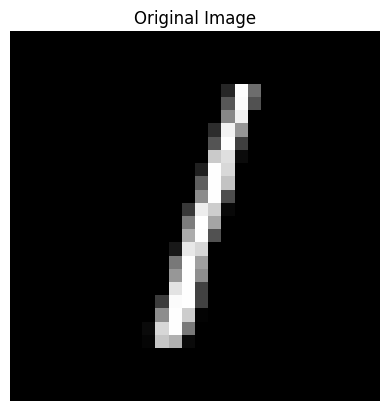

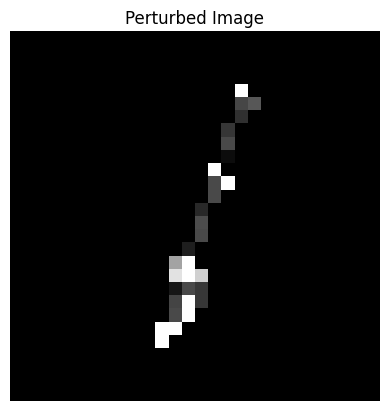

Image 4:
Original Label: 0
Initial Prediction: 0
Final Prediction: 6 


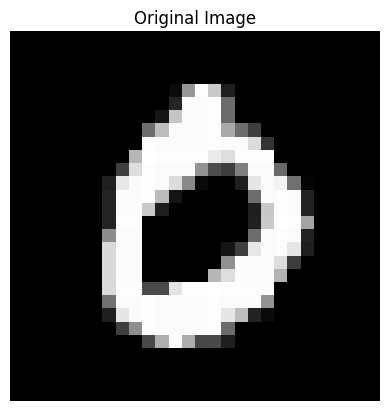

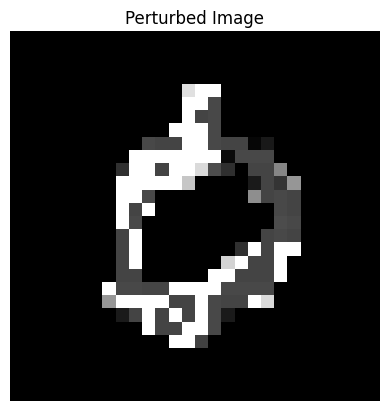

Image 5:
Original Label: 4
Initial Prediction: 4
Final Prediction: 4 (Attack failed)


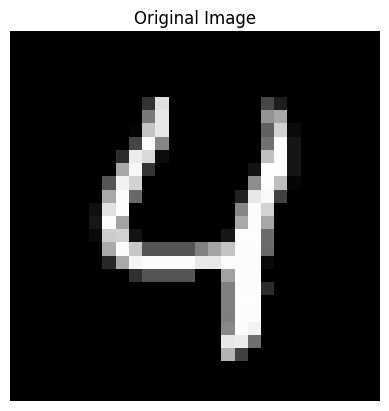

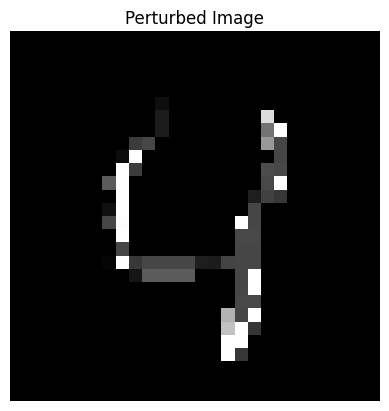

Image 6:
Original Label: 1
Initial Prediction: 1
Final Prediction: 8 


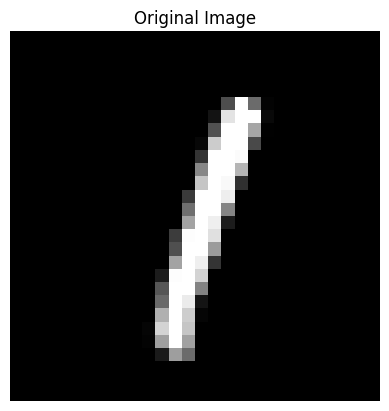

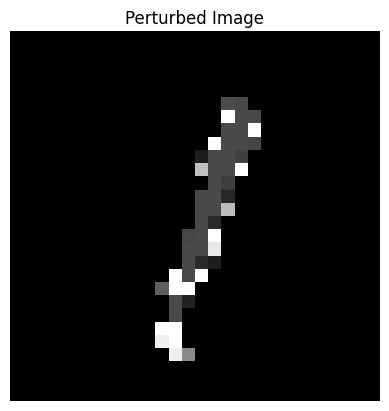

Image 7:
Original Label: 4
Initial Prediction: 4
Final Prediction: 8 


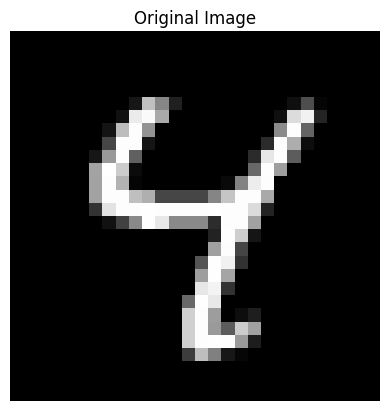

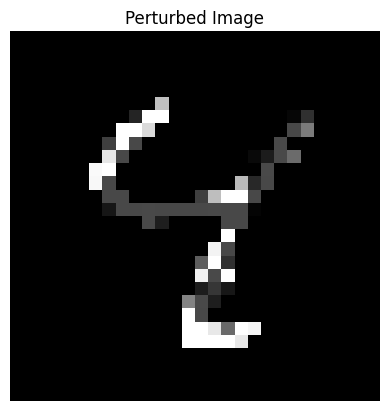

Image 8:
Original Label: 9
Initial Prediction: 9
Final Prediction: 4 


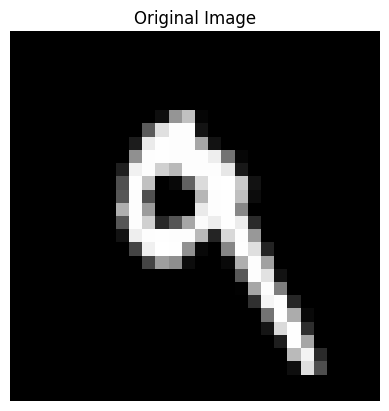

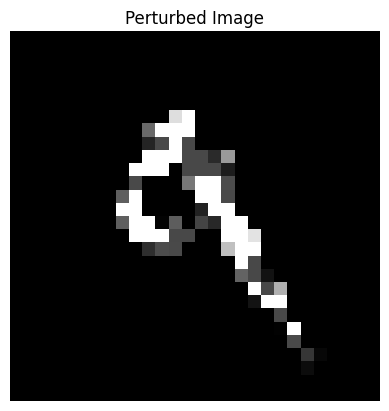

Image 9:
Original Label: 5
Initial Prediction: 5
Final Prediction: 6 


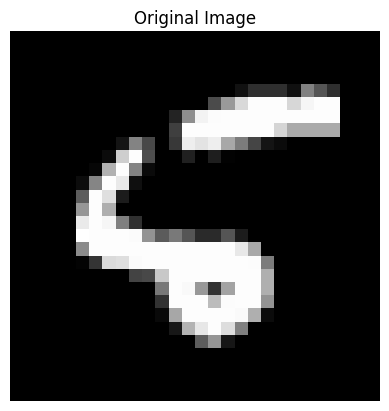

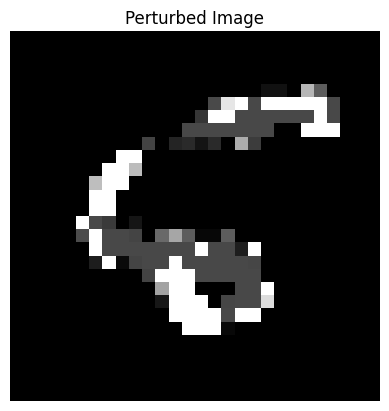

Image 10:
Original Label: 9
Initial Prediction: 9
Final Prediction: 7 


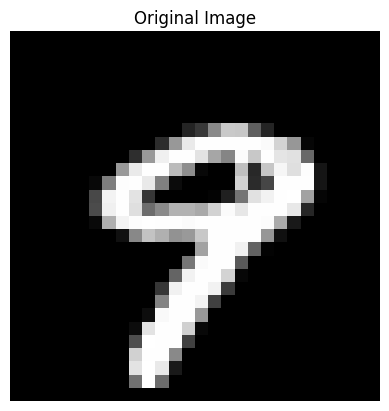

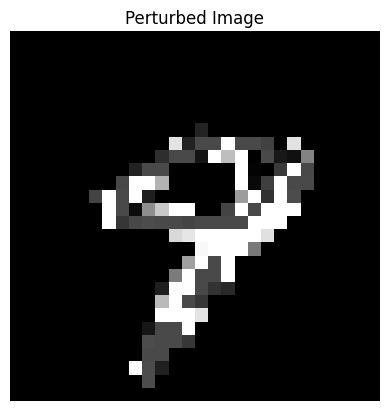

In [20]:
# 이미지 시각화를 위한 함수
def imshow(img, title):
    img = img.detach().cpu().numpy().squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# 결과 출력 및 시각화
for i in range(10):
    print(f"Image {i+1}:")
    print(f"Original Label: {labels[i].item()}")
    print(f"Initial Prediction: {init_preds[i].item()}")
    print(f"Final Prediction: {final_preds[i].item()} {'(Attack failed)' if final_preds[i].item() == labels[i].item() else ''}")

    # 원본 이미지 시각화
    imshow(images[i], title="Original Image")

    # 공격 이미지 시각화
    imshow(perturbed_images[i], title="Perturbed Image")

